# Lecture #14: Hamiltonian Monte Carlo
## AM 207: Advanced Scientific Computing
### Stochastic Methods for Data Analysis, Inference and Optimization
### Fall, 2021

<img src="fig/logos.jpg" style="height:150px;">

In [2]:
### Import basic libraries
import numpy
import scipy as sp
import pandas as pd
import sklearn as sk
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
from IPython.display import YouTubeVideo
%matplotlib inline

## Outline
1. Hierachical Generalized Linear Models
2. Sampling as Optimization
3. Hamiltonian Monte Carlo

# Hierarchical Generalized Linear Models

## Generalized Linear Models

We can add covariates to all the other common statistical models of data $Y^{(n)} \sim p(Y^{(n)}|\theta^{(n)})$!

The general scheme is:

1. Set $\mathbb{E}[Y^{(n)}] = \theta^{(n)} = g(\mathbf{w}^\top \mathbf{X}^{(n)})$, where $g$ is typically a non-linear function called the ***link function*** 

  *Note:* in literature, $g^{-1}$ is called the link function.<br><br>
  
2. Set the variance according to how the variance of $p(Y^{(n)}|\theta^{(n)})$ depends on $\theta$, $\mathrm{Var}[Y^{(n)}] = \phi f(\theta^{(n)})$, where $\phi$ is a constant.

These models are called ***generalized linear models***. Logistic regression is so called because $g^{-1}$ is the ***logistic function***.

## Kidney Cancer Dataset: Pooling vs Fully Independent Estimation
Rather than modeling the total incidents of kidney cancer, we collect information for each individual in each county. We can explain how the cancer rate depends on demogaphics.
\begin{aligned}
\theta^{(n)} &= \text{sigm}\left(\mathbf{w}^\top\mathbf{X}^{(n)}\right)\\
Y^{(n)} &\sim Ber(\theta^{(n)})
\end{aligned}
**1.** $Y^{(n)}$ is the cancer status of $n$-th individual<br>
**2.** $\mathbf{X}^{(n)}$ include income, level of education, access to preventative care, cost of living etc<br>
**3.** $\theta^{(n)}$ is the underlying cancer rate for the $n$-th individual.

**Pooled Estimation:** In the above model, we pooled the data across all counties. We implicitly assume that the cancer rate $\theta^{(n)}$ depends on demographic factors $\mathbf{X}$ in the **same way for every individual**.
$$
\text{Prob}[Y^{n} = 1 | \mathbf{X}^{(n)}] = \text{sigm}\left(-1 * \text{income} + 2 * \text{BMI} + \ldots\right)
$$
**Independent Estimation:**
Alternatively, we can estimate a $\mathbf{w}^{(c)}$ for each county $c$, fully independently:
\begin{aligned}
\theta^{(n, c)} &= \text{sigm}\left((\mathbf{w}^{(c)})^\top\mathbf{X}^{(n, c)}\right)\\
Y^{(n, c)} &\sim Ber(\theta^{(n, c)})
\end{aligned}
We implicitly assume that the way $\theta^{(n, c)}$ depends on demographic factors $\mathbf{X}$ **varies for every county independently**.
\begin{aligned}
\text{Prob}[Y^{(n, 1)} = 1 | \mathbf{X}^{(n, 1)}] &= \text{sigm}\left(0.1 * \text{income} - 0.2 * \text{BMI} + \ldots\right)\\
\text{Prob}[Y^{(n, 100)} = 1 | \mathbf{X}^{(n, 100)}] &= \text{sigm}\left(-1 * \text{income} + 2 * \text{BMI} + \ldots\right)
\end{aligned}

## Kidney Cancer Dataset : Hierachical vs Non-Hiearchical Models
**Bayesian Model:** Instead of assuming that the cancer rates in differen counties are fully independent. We can assume that the rates are **similar but differ from each other stochastically**.
\begin{aligned}
\mathbf{w}^{(c)} &\sim p(\mathbf{w} | \phi)\\
\theta^{(n, c)} &= \text{sigm}\left((\mathbf{w}^{(c)})^\top\mathbf{X}^{(n, c)}\right)\\
Y^{(n, c)} &\sim Ber(\theta^{(n, c)})
\end{aligned}

where $\phi$ is the set of hyperparameters of this model (i.e. you have to specify it). The prior $p(\mathbf{w} | \phi)$ expresses our belief that $\theta^{(n, c)}$'s are similar.

**Hierachical Model:** Rather than choosing $\phi$ arbitrarily, we can **infer $\phi$ from the data** by putting a prior on it.
\begin{aligned}
\phi & \sim p(\phi| a)\\
\mathbf{w}^{(c)} &\sim p(\mathbf{w} | \phi)\\
\theta^{(n, c)} &= \text{sigm}\left((\mathbf{w}^{(c)})^\top\mathbf{X}^{(n, c)}\right)\\
Y^{(n, c)} &\sim Ber(\theta^{(n, c)})
\end{aligned}
where $a$ is the set of hyperparameters of this model (i.e. you have to specify it).

## A Hierarchical Generalized Linear Model for Kidney Cancer

If we wanted to build an explanatory model for the regional differences in how cancer rate depends on demographic factors, we might want to consider a ***hierarchical generalized linear model*** as below:

\begin{aligned}
\sigma_{\mathbf{w}}^2 &\sim exp(1.5)\\
\mu &\sim \mathcal{N}(0, \mathbf{I})\\
\mathbf{w}^{(c)} &\sim \mathcal{N}(\mu, \sigma_{\mathbf{w}}^2 \mathbf{I})\\
\theta^{(n, c)} &= \text{sigm}\left((\mathbf{w}^{(c)})^\top\mathbf{X}^{(n, c)}\right)\\
Y^{(n, c)} &\sim Ber(\theta^{(n, c)})
\end{aligned}

The key object of interest for this model is the posterior 

$$p(\mu, \sigma_{\mathbf{w}}^2, \{\mathbf{w}^{(c)}\}_{c}, \{\mathbf{\theta}^{(n, c)}\}_{n, c}\, |\, \{Y_{n, c}\}_{n, c}).$$ 

Since there is no closed for this posterior, we must sample from it. 

**Question:** Should we expect that sampling from the posterior of these hierarchical models to be easy? What happened in HW#5 with your sampler?

# Sampling as Optimization

## When is Metropolis Hastings Efficient? 

Come up with a rule for what kinds of proposals get accepted. How many proposals will generally satisfy this rule?

In [22]:
HTML("""<video height="440" controls><source src="fig/mh_gaussian.mov" type="video/mp4"></video>""")

## When is Metropolis Hastings Inefficient? 
Come up with a rule for what kinds of proposals get accepted. How many proposals will generally satisfy this rule?

In [23]:
HTML("""<video height="440" controls><source src="fig/mh_donut.mov" type="video/mp4"></video>""")

## The Connection Between Energy and Density Functions

In ***simulated annealing*** we turn the objective function $U(q)$ into a pdf $\pi(q)$, but with higher mass where $U$ has lower values. This is the ***Gibbs distribution***:

$$
\pi(q) = \frac{1}{Z}\exp\left\{ -\frac{U(q)}{T}\right\},\;\; T \text{ is a constant}
$$

where $Z$ is the normalizing constant of the exponential part. The Gibbs distribution has a physical interpretation: $\pi(q)$ is the likelihood of being in state $q$ given the energy $U(q)$ of state $q$ and the temperature $T$. For now, we set $T=1$.

Using the same relationship, we can turn a probability distribution into an energy function
$$
U(q) = - \log \pi(q).
$$

**Motto:** negative gradient of the energy function points to the direct of steepest decrease in $U$ and the **steepest increase** in $\pi$.

## The Connection Between Optimization and Sampling

If we wanted to sample from high density regions of $\pi$, why don't we turn $\pi$ into an energy function $U(q) = - \log \pi(q)$ and use gradient descent to find the valleys of $U$ (and hence modes of $\pi$)? 

Why isn't gradient descent on $U$ a valid way to sample from $\pi$?

In [12]:
def plot_energy_gibbs(f, x, ax):
    ax[1].plot(x, f(x), color='red')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('Energy Function - look for min')

    ax[0].plot(x, -f(x), color='blue')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Probability Density Function - look for max')
    
    return ax

f = lambda x: x**4 + 1* x**3 - 10 * x**2 + 1
x = np.linspace(-4, 3.5, 100)

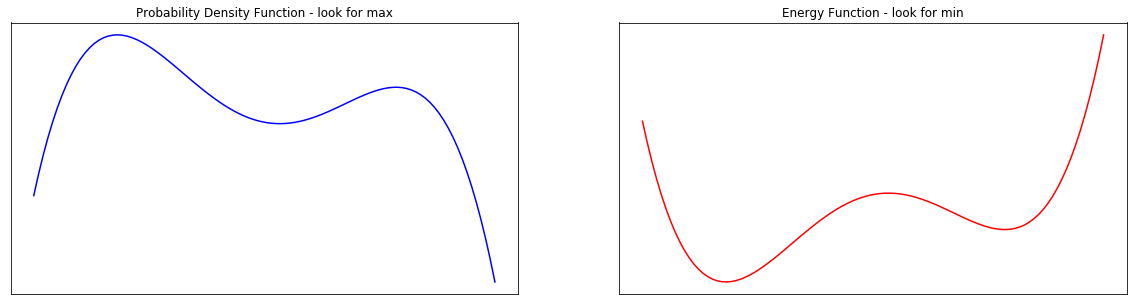

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = plot_energy_gibbs(f, x, ax)
plt.show()

## Gradient Descent with Random Momentum: Simulating Mechanics of Moving Particles
To randomly sample from $\pi$ we need to perform gradient-baesed descent on $U$ with some randomness to make sure we move around. But we need to make sure this randomness is controlled (i.e. doesn't overwhelm the information in the gradient).

What if we performed gradient descent with an initial random momentum? That is, we simulated the way a particle with mass would move on the graph of $U$ if we started its motion with a push (an intitial direction and magnitude of force):

**I.** at first, the particle would tend to travel in the direction of the initialization<br>
**II.** eventually, gravity will pull it towards the minima (it will perform gradient descent)

<img src="fig/rollercoaster.png" style="height:300px;">

## Sampling by Physical Simulation

We can now sketch a sampler of $\pi$ based on the simulations physical explorations of the graph of it's energy function $U$:

1. start at a random $q$, pick a mass $M$
2. repeat:
  1. start at the current sample $q_{\text{current}}$
  2. pick a random momentum vector (random direction and magnitude of force)
  3. simulate, for a period of $T$ seconds, the movement of a particle with mass $M$ moving on the graph of $U$ with this momentum
  4. the $q$-coordinate(s) of where the particle lands at the $T$-th second is the new sample $q_{\text{new}}$
  5. set $q_{\text{current}}\leftarrow q_{\text{new}}$

<img src="fig/gibbs.jpg" style="height:200px;">

In [24]:
HTML("""<video height="440" controls><source src="fig/hmc_donut.mov" type="video/mp4"></video>""")

# Hamiltonian Monte Carlo

## Hamiltonian Motion as Differential Equations

What does it mean to simulate the movement of a particle on the graph of $U$? It means to exchange potential energy (height) with kinetic energy (related to speed) in a way that obeys the ***conservation of total energy***. 

A physical properties of system with position $q(t)$ and momentum $p(t)$ is described by a function $H(q, p)$ called the ***Hamiltonian***. We will always choose a Hamiltonian that decomposes as the sum of potential and kinetic energy as follows:
\begin{aligned}
\underbrace{H(q, p)}_{\text{total}} = \underbrace{U(q(t))}_{\text{potential}} + \underbrace{K(p(t))}_{\text{kinetic}}
\end{aligned}
How the system $(q, p)$ changes over time is described by the partial derivatives of $H$:
\begin{aligned}
\frac{dq}{dt} = \underbrace{\frac{\partial H}{\partial p}}_{\text{function of $t$}},\quad\quad \frac{dp}{dt} = \underbrace{-\frac{\partial H}{\partial q}}_{\text{function of $t$}}
\end{aligned}
This forms a system of ***differential equations*** -- equations describing the derivatives/gradients of a function. We call this a ***Hamiltonian system***.

Say the system is at $(q_0, p_0)$ at time $t=0$, the system's state at time $t = T$ is given by **integrating** the differential equations from $t=0$ to $t=T$ and solving for constants based on $q(0) = q_0$, $p(0) = p_0$. The map $\phi(T)$ transforming the state $(q_0, p_0)$ to the state at $(q_T, p_T)$ is called the ***flow*** of the Hamiltonian system. The principle of conservation of total energy says that $H(q, p)$ is constant along every point $q_t, p_t$ on every flow.

## Hamiltonian Monte Carlo: with Exact Integration

Let $\pi(q)$ be our target distribution with $q\in \mathbb{R}^D$. We turn $\pi$ into an energy function $U(q)$ by $U(q) = - \log(\pi(q))$. We choose a kinetic energy function $K(p)$. We fix $t = T$.

0. start with a random $q^{(0)}\in\mathbb{R}^D$
1. repeat:
  1. (**kick-off**) sample a random momentum from the Gibbs distribution of $K(p)$, i.e.
    $p^{(current)} \sim \frac{1}{Z} \exp\{-K(p)\}$.
    
  2. (**simulate movment**) simulate Hamiltonian motion for a time interval of length $T$, i.e. start at $(q^{(current)}, p^{(current)})$ and find $(q^{(\text{time }T)}, p^{(\text{time }T)})$. You need to integrate $\frac{dq}{dt} = \frac{\partial H}{\partial p}, \frac{dp}{dt} = -\frac{\partial H}{\partial q}$!
  
  3. accept $q^{(current)}$ as a new sample: $q^{(current)} \leftarrow q^{(\text{time }T)}$.
  
**Questions:** is this a correct way to sample from $\pi$? But isn't the integration in Step B hard?

## Correctness of HMC with Exact Integration
Two important properties of Hamiltonian dynamics:

I. (**Reversibility**) The flow $\phi(T)$ of a Hamiltonian system is one-to-one and onto for every interval length $T$, i.e. given $(q^{(\text{time }T)}, p^{(\text{time }T)})$ we can compute the point of origin $(q^{(\text{time }0)}, p^{(\text{time }0)})$. 

II. (**Volume Preserving**) It's easy to verify that the vector field of a Hamiltonian system is divergence free, which will imply that the flow $\phi(T)$ is volume preserving -- if $A\subset \mathbb{R}^D$ has volume $V$ then the image of $A$ under $\phi(T)$ has volume $V$.

The above two properties imply detailed balance for HMC with respect to the joint distribution (see readings):
$$\pi(q, p) = \frac{1}{Z} \exp\{-H(q, p) \}.$$
But we can rewrite the joint distribution $\pi(q, p)$:
\begin{aligned} 
\pi(q, p) = \frac{1}{Z} \exp\{-U(q) - K(p) \} &= \exp\{-U(q)\} \frac{1}{Z}\exp\{-K(p)\}\\
&= \exp\{\log(\pi(q)) \} \frac{1}{Z}\exp\{-K(p)\}\\
&= \pi(q)\frac{1}{Z}\exp\{-K(p)\}
\end{aligned}
That is, $q$ and $p$ are independent. Hence, sampling from $\pi(q, p)$ and ignoring $p$ gives us samples from $\pi(q)$.

**Question:** What about irreducibility and aperiodicity?

## Approximating Flows: Sympletic Integrators

Simulating Hamiltonian dynamics for a time period of length $T$, using the flow $\phi(T)$, requires that we integrate the equations in the Hamiltonian system with respect to $t$, 
$$\frac{dq}{dt} = \frac{\partial H}{\partial p}, \quad\quad \frac{dp}{dt} = -\frac{\partial H}{\partial q}$$
This is generally intractable to do analytically! In HMC, we approximate the dynamics by:

1. discretizing the time period $[0, T]$ into $L$ chunks each with length $\epsilon$.
2. **approximating** the flow for a time period of length $\epsilon$.

A common method of approximating the flow is called the ***leap-frog integrator***. This integrator has the special property of being **reversible** and **volume-preserving**. 

This means that replacing exact Hamiltonian dynmaics in HMC with the leap-frog integration will not obviously ruin detailed balance!

## Approximating Flows: Adjusting for Error

But the approximation is not exact! The longer the time period $\epsilon$ the more error in the approximation. The more steps in your simulation (i.e. the longer $T$ is) the more these errors will accumulate. To ensure the correctness of the sampling, **we need to add a Metropolis-Hastings step** so that we can potentially reject the sample from the approximation.

<img src="fig/integrator.jpg" style="height:300px;">

## Hamiltonian Monte Carlo: with the Leap Frog Integrator

Let $\pi(q)$ be our target distribution with $q\in \mathbb{R}^D$. We turn $\pi$ into an energy function $U(q)$ by $U(q) = - \log(\pi(q))$. We choose a kinetic energy function $K(p)$.

**0.** start with a random $q^{(0)}\in\mathbb{R}^D$<br>

**1.** repeat:<br>
$\quad$**A.** (**kick-off**) sample a random momentum from the Gibbs distribution of $K(p)$, i.e.
    $p^{(current)} \sim \frac{1}{Z} \exp(-K(p))$.<br>
    
$\quad$**B.** (**simulate movement**) simulate Hamiltonian motion for $L$ steps each with time interval $\epsilon$, using the leap-frog integrator. <br>
$\quad$$\quad$**a.** Repeat for T - 1 times, for $p^{(\text{step } 0)} = p^{(current)}$, $q^{(\text{step } 0)} = q^{(current)}$:<br>
$\quad$$\quad$$\quad$**i.** (**half-step update for momentum**) $p^{(\text{step } t + 1/2)} \leftarrow  p^{(\text{step } t)} - \epsilon/2 \frac{\partial U}{\partial q}(q^{(\text{step } t)})$<br>
$\quad$$\quad$$\quad$**ii.*** (**full-step update for position**) $q^{(\text{step } t + 1)} \leftarrow q^{(\text{step } t)} + \epsilon \frac{\partial K}{\partial p}(p^{(\text{step } t + 1/2}))$<br>
$\quad$$\quad$$\quad$**iii.** (**half-step update for momentum**)$p^{(\text{step } t + 1)} \leftarrow  p^{(\text{step } t + 1/2)} - \epsilon/2 \frac{\partial U}{\partial q}(q^{(\text{step } t + 1)})$<br>
$\quad$$\quad$**b.** (**reverse momentum**) $p^{(\text{step } T)} \leftarrow -p^{(\text{step } T)}$<br>

$\quad$**C.**(**correction for simulation error**) implement Metropolis-Hasting accept mechanism: <br>
$\quad$$\quad$**a.** compute $\alpha = \min\left(1, \exp\left\{H(q^{(current)}, p^{(current)}) - H(q^{(\text{step } T)}, p^{(\text{step } T)})\right\} \right)$<br>
$\quad$$\quad$**b.** sample $U\sim U(0, 1)$, if $U \leq \alpha$ then accept, else keep old sample

## HMC with Leap Frog Integrator in Action

In [57]:
HTML("""<video height="440" controls><source src="fig/hmc_donut.mov" type="video/mp4"></video>""")

## Hamiltonian Monte Carlo: Summary

Given a target distribution $\pi$, we
1. turn $\pi(q)$ into a potential energy function $U(q) = - \log(\pi(q))$. We choose a kinetic energy function $K(p)$.
2. generate samples $\{ q_s\}$ by approximately simulating Hamiltonian dynamics for a particle (i.e. realistic movement on the graph of $U(q)$) with random intialization.
3. for each sample we need to accept based on a Metropolis-Hastings mechanism because the simulation is not exact.

**Design choices:**
1. (**Advanced**) kinetic energy function $K(p)$ -- needs to be one such that you can easily sample from its Gibbs distribuion $\frac{1}{Z} \exp(-K(p))$.
2. (**Advanced**) integrator to approximate Hamiltonian flow -- this needs to be volume-preserving and reversible.
3. (**Everyone**) number and size of discrete time steps for discrete integrators.

  What happens when the step sizes are large and we take many steps? What happens when the step sizes are tiny and we take few?

## Example: Euclidean-Gaussian Kinetic Energy

Let $q\in \mathbb{R}^D$. Let $\pi(q)$ be our target distribution so that $U(q) = -\log(\pi(q))$ defines our potential energy function. Let's choose the mass of this system to be a matrix $M = m \mathbf{I}_{D\times D}$. Then the ***Euclidea-Guassian kinetic energy*** function is defined as

$$
K(p) = \frac{1}{2} p^\top M^{-1} p + \frac{1}{2}\log|M| + \frac{D}{2} \log(2\pi)
$$

The Gibbs distribution for $K(p)$ is 

$$
\pi(p) = \frac{1}{Z}\exp\{-K(p)\} = \frac{1}{Z} \frac{1}{(2\pi)^{D/2}|M|^{1/2}} \exp\left\{-\frac{1}{2}p^\top M^{-1} p\right\}
$$

Since $\exp\{-K(p)\}$ is the pdf of the normal distribution $\mathcal{N}(0, M)$, it already integrates to 1, and hence $Z =1$.

Now, the partial derivatives of $H(q, p) = U(q) + K(P)$ with respect to $q$ and $p$ are
\begin{aligned}
\frac{\partial U}{\partial q} &= - \frac{\frac{\partial}{\partial q}\pi(q)}{\pi(q)}\\
\frac{\partial K}{\partial p} &= \frac{1}{m} p
\end{aligned}

Thus, HMC with the above choices becomes

0. start with a random $q^{(0)}\in\mathbb{R}^D$
1. repeat:
  1. (**kick-off**) sample a random momentum from the Gibbs distribution of $K(p)$, i.e.
    $p^{(current)} \sim \mathcal{N}(0, M)$.
    
  2. (**simulate movement**) simulate Hamiltonian motion for $L$ steps each with time interval $\epsilon$, using the leap-frog integrator. 
  
    1. Repeat for T - 1 times, for $p^{(\text{step } 0)} = p^{(current)}$, $q^{(\text{step } 0)} = q^{(current)}$:
       1. (**half-step update for momentum**) $p^{(\text{step } t + 1/2)} \leftarrow  p^{(\text{step } t)} - \epsilon/2 \frac{\partial U}{\partial q}(q^{(\text{step } t)})$
       2. (**full-step update for momentum**) $q^{(\text{step } t + 1)} \leftarrow q^{(\text{step } t)} + \epsilon \frac{1}{m} p^{(\text{step } t + 1/2)}$
       3. (**half-step update for momentum**) $p^{(\text{step } t + 1)} \leftarrow  p^{(\text{step } t + 1/2)} - \epsilon/2 \frac{\partial U}{\partial q}(q^{(\text{step } t + 1)})$
     
   2. (**reverse momentum**) $p^{(\text{step } T)} \leftarrow -p^{(\text{step } T)}$
  
  3. (**correction for simulation error**) implement Metropolis-Hasting accept mechanism: 
    1. compute $\alpha = \min\left(1, \exp\left\{H(q^{(current)}, p^{(current)}) - H(q^{(\text{step } T)}, p^{(\text{step } T)})\right\} \right)$
    2. sample $U\sim U(0, 1)$, if $U \leq \alpha$ then accept, else keep old sample

## HMC for Multimodal Distributions

In [55]:
HTML("""<video height="440" controls><source src="fig/hmc_multimodal.mov" type="video/mp4"></video>""")